# 7-Data-Mining

# OBJ 1 - Random Forest Classifier model 

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierModel").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col, handleInvalid='keep', stringOrderType="frequencyDesc").fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier with a seed
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target", seed=42)

# Create a parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Set up the cross-validator
evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=4,  # We can adjust the number of folds as needed
                                 seed=42)

# Run cross-validation and choose the best set of parameters
cv_model = cross_validator.fit(train_data)

# Make predictions on the test set using the best model
cv_predictions = cv_model.transform(test_data)

# Fit the Random Forest model on the entire training set
final_model = rf_classifier.fit(train_data)

# Calculate accuracy
accuracy = evaluator.evaluate(cv_predictions)
print("Accuracy:", accuracy)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 08:54:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/10 08:54:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Accuracy: 0.8138921657067518


encoded_Gender: 0.21852124126569453
encoded_AgeGroup: 0.02663052235862524
encoded_Ethnicity: 0.7548482363756803


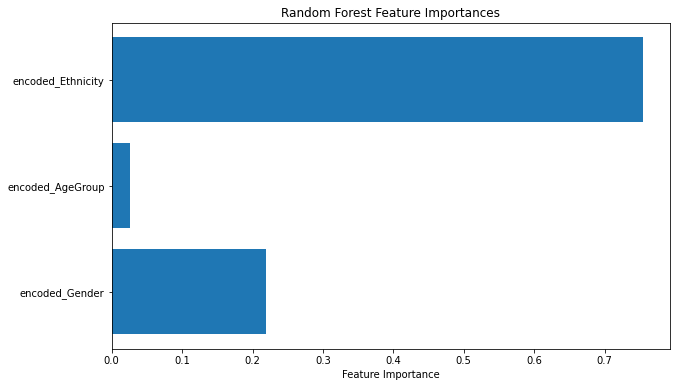

In [3]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierModel").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col, handleInvalid='keep', stringOrderType="frequencyDesc").fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier with a seed
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target", seed=42)

# Fit the Random Forest model on the entire training set
final_model = rf_classifier.fit(train_data)

# Print feature importances
feature_importances = final_model.featureImportances.toArray()
for i, feature in enumerate(feature_cols):
    print(f"{feature}: {feature_importances[i]}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()


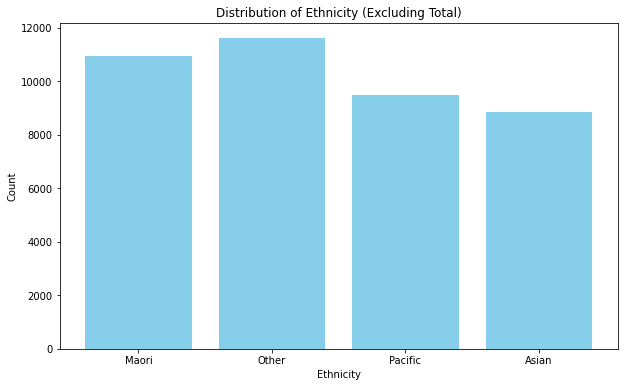

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

#'df' is the Spark DataFrame
ethnicity_counts = df.filter(df['Ethnicity'] != 'Total').groupBy('Ethnicity').count().toPandas()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts['Ethnicity'], ethnicity_counts['count'], color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity (Excluding Total)')
plt.show()


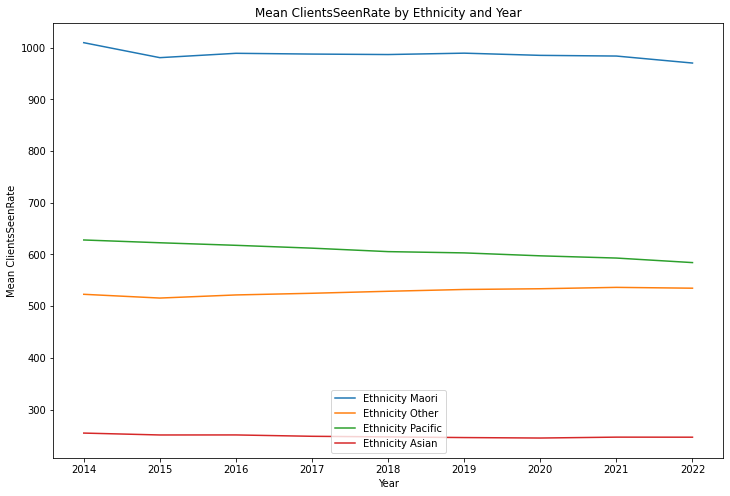

In [5]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F

#'df' is the Spark DataFrame
spark = SparkSession.builder.appName("LineGraphEthnicityYear").getOrCreate()

# Filter out rows with 'Total' Ethnicity
df_filtered = df.filter(col('Ethnicity') != 'Total')

# Calculate the mean of ClientsSeenRate for each Ethnicity and Year
mean_clients_seen_rate = df_filtered.groupBy('Ethnicity', 'Year') \
    .agg(F.mean('ClientsSeenRate').alias('MeanClientsSeenRate'))

# Sort by Year
windowSpec = Window.partitionBy('Ethnicity').orderBy('Year')
mean_clients_seen_rate = mean_clients_seen_rate.withColumn('MeanClientsSeenRate', F.mean('MeanClientsSeenRate').over(windowSpec))

# Get unique values of Ethnicity
unique_ethnicities = mean_clients_seen_rate.select('Ethnicity').distinct().rdd.flatMap(lambda x: x).collect()

# Plotting the graph
plt.figure(figsize=(12, 8))

# Iterate over unique ethnicities
for ethnicity in unique_ethnicities:
    data_subset = mean_clients_seen_rate.filter(col('Ethnicity') == ethnicity).orderBy('Year').collect()
    years = [row['Year'] for row in data_subset]
    mean_clients_seen_rates = [row['MeanClientsSeenRate'] for row in data_subset]
    plt.plot(years, mean_clients_seen_rates, label=f'Ethnicity {ethnicity}')

plt.xlabel('Year')
plt.ylabel('Mean ClientsSeenRate')
plt.title('Mean ClientsSeenRate by Ethnicity and Year')
plt.legend()
plt.show()




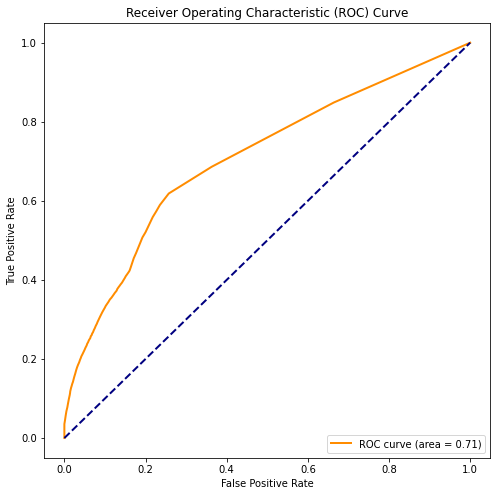

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierCV").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col).fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target")

# Create a parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Set up the cross-validator
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                                 numFolds=4,  # We can adjust the number of folds as needed
                                 seed=42)

# Run cross-validation and choose the best set of parameters
cv_model = cross_validator.fit(train_data)

# Make predictions on the test set using the best model
cv_predictions = cv_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
cv_accuracy = evaluator.evaluate(cv_predictions)

# Plot the ROC curve
def plot_roc_curve(predictions, label_col='Target', raw_prediction_col='rawPrediction'):
    y_true = [row[label_col] for row in predictions.select(label_col).collect()]
    y_scores = [row[raw_prediction_col][1] for row in predictions.select(raw_prediction_col).collect()]

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot the ROC curve for the cross-validated model
plot_roc_curve(cv_predictions)



In [16]:
from pyspark.sql import SparkSession

evaluator = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
auc_pr = evaluator.evaluate(cv_predictions)
print("AUC-PR:", auc_pr)

AUC-PR: 0.4285876294737386


In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(cv_predictions)
print("F1 Score:", f1_score)


F1 Score: 0.7548203248573726


In [18]:
true_positives = cv_predictions.filter("prediction = 1 AND Target = 1").count()
false_positives = cv_predictions.filter("prediction = 1 AND Target = 0").count()
false_negatives = cv_predictions.filter("prediction = 0 AND Target = 1").count()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.6691769768692846
Recall: 0.10918985341876591


# OBJ 2 - K-means Clustering

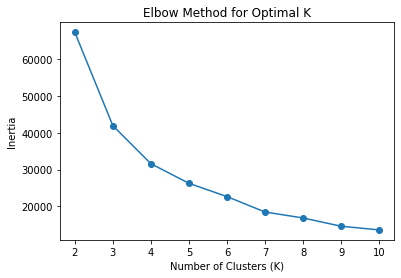

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features']
df = df.select(selected_features)

# Determine the optimal number of clusters using the elbow method
k_values = range(2, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df)
    inertia_values.append(model.summary.trainingCost)

# Plot the elbow method to choose the optimal K
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [20]:
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Compute silhouette scores for different values of K
for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df)
    predictions = model.transform(df)

    # Convert PySpark DataFrame to Pandas DataFrame
    pandas_predictions = predictions.select('TeamIndex', 'prediction', 'scaled_features').toPandas()

    # Extract relevant columns
    labels = pandas_predictions['prediction']
    
    # Extract values from DenseVectors
    features = np.array([vector.toArray() for vector in pandas_predictions['scaled_features']])

    # Compute silhouette score
    silhouette = silhouette_score(features, labels)
    print(f"For K={k}, Silhouette Score: {silhouette}")

For K=2, Silhouette Score: 0.9350953463596291


For K=3, Silhouette Score: 0.9122309667821634
For K=4, Silhouette Score: 0.9013891116921409


For K=5, Silhouette Score: 0.842274323430666


For K=6, Silhouette Score: 0.8478161218391959
For K=7, Silhouette Score: 0.8471642404473244


For K=8, Silhouette Score: 0.8368858199094544


For K=9, Silhouette Score: 0.8073059668687405


For K=10, Silhouette Score: 0.7913471894360916


In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')

# Create a new instance of the model and fit it
model = kmeans.fit(df)

# Add the 'cluster' column to the original DataFrame
clustered_df = model.transform(df)

# Display the results
clustered_df.select('TeamIndex', 'scaled_features', 'cluster').show()

+---------+--------------------+-------+
|TeamIndex|     scaled_features|cluster|
+---------+--------------------+-------+
|      5.0|[-0.2801231818286...|      0|
|      0.0|[1.12158384180993...|      0|
|      1.0|[-0.2531116218410...|      0|
|      7.0|[-0.2849466746835...|      0|
|      2.0|[-0.2068060904339...|      0|
|     10.0|[-0.2839819761125...|      0|
|      8.0|[-0.2849466746835...|      0|
|      6.0|[-0.2733702918317...|      0|
|      5.0|[-0.2675821004058...|      0|
|      0.0|[5.82738347106589...|      1|
|      1.0|[-0.2193471718566...|      0|
|      7.0|[-0.2637233061219...|      0|
|      4.0|[-0.2801231818286...|      0|
|      2.0|[0.10286215085169...|      0|
|      8.0|[-0.2810878803996...|      0|
|      6.0|[-0.0621013047864...|      0|
|      5.0|[-0.1170891233324...|      0|
|      0.0|[9.90516433061181...|      1|
|      1.0|[2.21651671987584...|      2|
|      3.0|[-0.0881481662029...|      0|
+---------+--------------------+-------+
only showing top

In [22]:
# Profile the clusters
cluster_profiles = clustered_df.groupBy('cluster').mean()
cluster_profiles.show()

+-------+--------------------+------------+
|cluster|      avg(TeamIndex)|avg(cluster)|
+-------+--------------------+------------+
|      1|0.029900332225913623|         1.0|
|      2|  0.3950381679389313|         2.0|
|      0|   4.702726252115484|         0.0|
+-------+--------------------+------------+



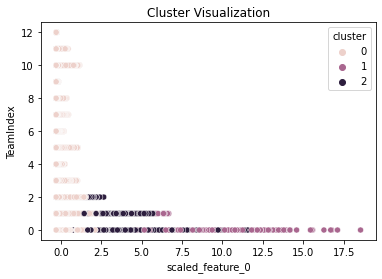

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame for easier plotting
pandas_df = clustered_df.toPandas()

# Extract individual components from the DenseVector
for i in range(len(pandas_df['scaled_features'][0])):
    pandas_df[f'scaled_feature_{i}'] = pandas_df['scaled_features'].apply(lambda x: x[i])

# Scatter plot to visualize clusters
sns.scatterplot(x='scaled_feature_0', y='TeamIndex', hue='cluster', data=pandas_df)
plt.title("Cluster Visualization")
plt.show()

In [24]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='cluster', metricName='silhouette')

# Calculate Silhouette score
silhouette_score = evaluator.evaluate(clustered_df)
print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.9583707296274857


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features']
df = df.select(selected_features)

# Split the data into training and testing sets (70/30 split)
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K on the training set
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')
model = kmeans.fit(train_df)

# Add the 'cluster' column to the original DataFrame
clustered_train_df = model.transform(train_df)
clustered_test_df = model.transform(test_df)

# Display the results for the testing set
print("Results on Testing Set:")
clustered_test_df.select('TeamIndex', 'scaled_features', 'cluster').show()

# Evaluate the model on the testing set using ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='cluster')
silhouette = evaluator.evaluate(clustered_test_df)
print(f"Silhouette Score on Testing Set: {silhouette}")


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 04:55:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Results on Testing Set:
+---------+--------------------+-------+
|TeamIndex|     scaled_features|cluster|
+---------+--------------------+-------+
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
+---------+--------------------+-

Silhouette Score on Testing Set: 0.9597716632747232


In [3]:
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# Selecting the features for Davies-Bouldin Index calculation
features_col = 'scaled_features'
prediction_col = 'cluster'
selected_features = ['TeamIndex', features_col, prediction_col]
selected_df = clustered_test_df.select(selected_features)

# Collecting the predictions and features into a list
predictions_and_features = selected_df.collect()

# Extracting the features and predictions
features = [np.array(row[features_col].toArray()) for row in predictions_and_features]
predictions = [row[prediction_col] for row in predictions_and_features]

# Calculating the Davies-Bouldin Index manually
num_clusters = optimal_k
cluster_centroids = [np.array(model.clusterCenters()[i]) for i in range(num_clusters)]

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def calculate_davies_bouldin_index():
    cluster_distances = []
    for i in range(num_clusters):
        cluster_i_indices = [index for index, pred in enumerate(predictions) if pred == i]
        centroid_i = cluster_centroids[i]

        intra_cluster_distances = []
        for index in cluster_i_indices:
            feature_vector = features[index]
            intra_cluster_distances.append(euclidean_distance(centroid_i, feature_vector))

        average_intra_cluster_distance = np.mean(intra_cluster_distances)
        inter_cluster_distances = []

        for j in range(num_clusters):
            if j != i:
                centroid_j = cluster_centroids[j]
                inter_cluster_distances.append(euclidean_distance(centroid_i, centroid_j))

        average_inter_cluster_distance = np.mean(inter_cluster_distances)
        cluster_distances.append(average_intra_cluster_distance / average_inter_cluster_distance)

    davies_bouldin_index = np.mean(cluster_distances)
    return davies_bouldin_index

# Calculate Davies-Bouldin Index
davies_bouldin_index = calculate_davies_bouldin_index()
print(f"Davies-Bouldin Index on Testing Set: {davies_bouldin_index}")


Davies-Bouldin Index on Testing Set: 0.26866610332469826
